# Setup

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

# the starred components
from starred.deconvolution.deconvolution import Deconv, setup_model
from starred.deconvolution.loss import Loss
from starred.optim.optimization import Optimizer
from starred.deconvolution.parameters import ParametersDeconv
from starred.utils.noise_utils import propagate_noise
from starred.plots.plot_function import view_deconv_model

# lightcurver utilities for error bars and light curve manipulation:
from lightcurver.utilities.starred_utilities import get_flux_uncertainties
from lightcurver.utilities.lightcurves_postprocessing import group_observations, convert_flux_to_magnitude

# Importation of data

In [2]:
decfile = 'cutouts_195_PSJ0030-1525.h5'

# load everything from our h5 file:
with h5py.File(decfile, 'r') as f:
    data = np.array(f['data'])
    noisemap = np.array(f['noisemap'])
    # the narrow PSFs:
    s = np.array(f['psf'])
    # at what subsampling the PSFs were modelled:
    subsampling_factor = np.unique(f['subsampling_factor'])[0]

    # very important: scale the data so its values are ~0-1, makes 
    # the optimizers much more stable.
    scale = np.nanmax(data)
    data /= scale
    noisemap /= scale

    # important to calculate meaningful error bars, the
    # normalization uncertainty of each frame
    rel_norm_errs = np.array(f['relative_normalization_error'])

    # the meta data.
    seeings = np.array(f['seeing'])
    mjds = np.array(f['mjd'])
    zeropoint = np.array(f['global_zeropoint'])    
    frame_ids = np.array(f['frame_id'])
    subsampling_factor = np.unique(f['subsampling_factor'])[0]
    wcs = np.array(f['wcs'])

im_size = data.shape[1]
im_size_up = subsampling_factor * im_size
epochs = data.shape[0]
print(f"We have {epochs} epochs, the cutouts have size {im_size}. The deconvolution will live on a grid of size {im_size_up}.")

We have 334 epochs, the cutouts have size 32. The deconvolution will live on a grid of size 64.


We can plot the total flux in each cutout, just to make sure our normalization isn't completely wrong.

Text(0.5, 1.0, 'total flux in entire cutout')

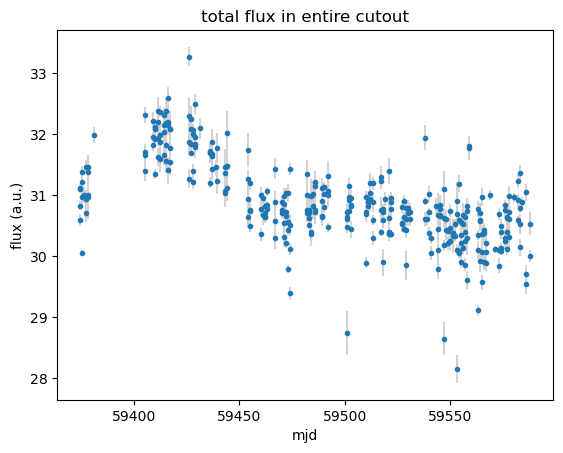

In [3]:
# replace by your favourite matplotlib backend for interactive figures:
%matplotlib widget
plt.figure()
flux_per_frame = np.sum(data, axis=(1,2))
plt.errorbar(mjds, flux_per_frame, yerr=flux_per_frame*rel_norm_errs, fmt='.', ecolor='lightgray')
plt.xlabel('mjd')
plt.ylabel('flux (a.u.)')
plt.title('total flux in entire cutout')

We see a few outliers, but nothing too dramatic. The scatter could be better: it is slightly bigger within each night than the normalization errors. But we are summing over the entire frame, as such we are accumulating a lot of noise and other defects.

# Deconvolution of best frames

Let us deconvolve the best frames to get an idea of the astrometry of the point sources and look of the background.

In [4]:
down = np.percentile(seeings, 0)
up = np.percentile(seeings, 5)
selected_indices = np.where((seeings >= down)*(seeings<up))
best_data = data[selected_indices]
best_noise = noisemap[selected_indices]
best_s = s[selected_indices]
best_frame_ids = frame_ids[selected_indices]
print(f'Max seeing: {up:.02f}", with {len(best_data)} frames selected.')


Max seeing: 0.97", with 17 frames selected.


Now we assign an initial guess of the astrometry of the point sources. We give each point source a label.

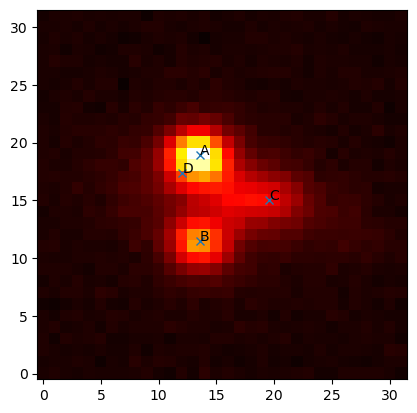

In [5]:
point_sources = {
    'A': (13.59, 18.95),
    'B': (13.54, 11.49),
    'C': (19.55, 15.05),
    'D': (12.04, 17.37),
}

point_sources_labels = sorted(point_sources.keys())
xs = np.array([coords[0] for ps, coords in point_sources.items()])
ys = np.array([coords[1] for ps, coords in point_sources.items()])

plt.figure()
plt.imshow(best_data[0], origin='lower', cmap='hot')
plt.plot(xs, ys, 'x')
#plt.plot(ras-0.5, decs+0.5, 'x', color='red')
for n, x, y in zip(point_sources_labels, xs, ys):
    plt.text(x, y, n)

Ok, now we define the `STARRED` model. We need to provide a relatively good guess of the astrometry and intensities in each point source. Ideally, we want to see the background appear point-source free. But we can leave most of the fine tuning to the optimizer, here we'll focus on making the first epoch look decent.

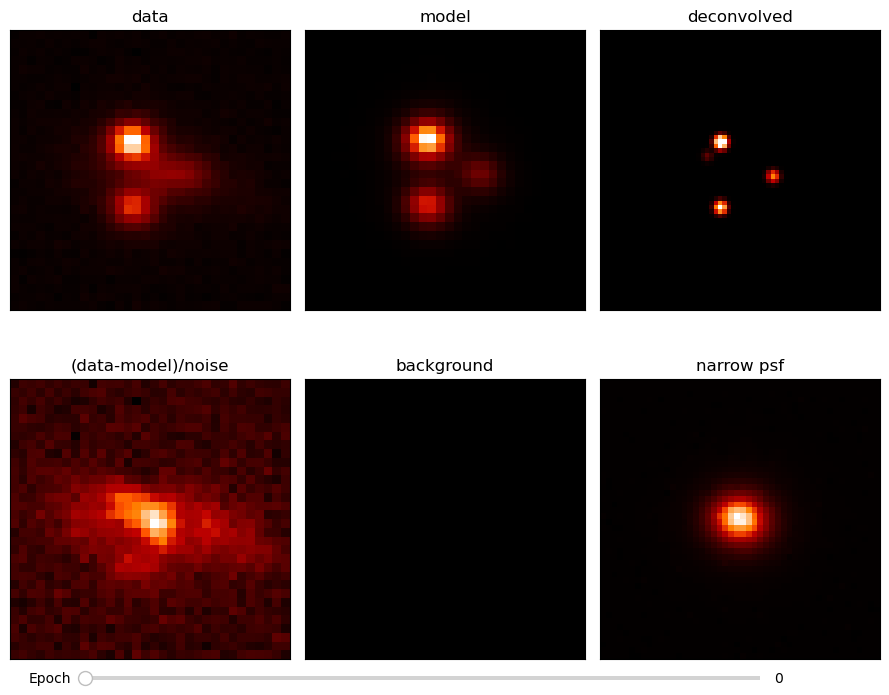

In [6]:
# starred has the origin of its coordinates at the center of the image,
# so we'll remove half the width of the cutout from our coordinates.
offset = (im_size-1) / 2. 

initial_c_x = xs - offset
initial_c_y = ys - offset 
# we also need to provide an initial guess of the intensities of each point source:
initial_a = [10.5, 6., 2.9, 0.5]
# which we repeat (one set per frame)
initial_a = len(best_data)*initial_a
                           
model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(best_data, 
                                                                       best_noise**2, 
                                                                       best_s, 
                                                                       initial_c_x,
                                                                       initial_c_y,
                                                                       subsampling_factor,
                                                                       initial_a)

# first look at what our model is like given our initial guess:
view_deconv_model(model, kwargs_init, best_data, best_noise**2)

Now we can start optimizing / fitting the pixels. We'll start by only optimizing the translations.

/home/fred/Documents/starred_dev/starred/starred/deconvolution/loss.py:135: UserWarning: lambda is not normalized. Provide the weight map !
  warnings.warn('lambda is not normalized. Provide the weight map !')


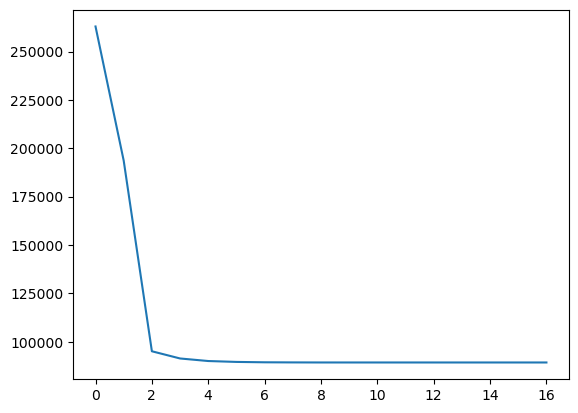

In [7]:
# make all arguments fixed:
kwargs_fixed = deepcopy(kwargs_init)
# but remove the translations from the fixed parameters.
del kwargs_fixed['kwargs_analytic']['dx']
del kwargs_fixed['kwargs_analytic']['dy']

# this is starred boilerplate code, creating an object handling parameters,
# a loss function, and an optimizer combining the two.
parameters = ParametersDeconv(kwargs_init=kwargs_init, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

loss = Loss(best_data, model, parameters, best_noise**2)


optim = Optimizer(loss, parameters, method='l-bfgs-b')

# optimize:
best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(maxiter=600)
# extract the optimized arguments:
kwargs_partial1 = deepcopy(parameters.best_fit_values(as_kwargs=True))

# plot the behaviour of the loss.
plt.figure()
plt.plot(extra_fields['loss_history'])
plt.show()


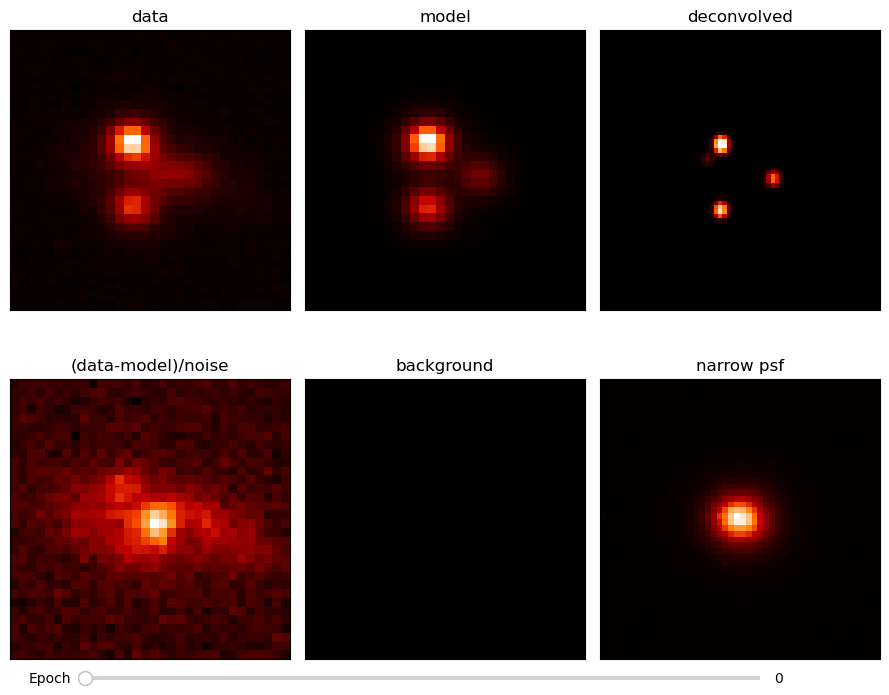

In [8]:
# let's see how we're doing
view_deconv_model(model, kwargs_partial1, best_data, best_noise**2)

We've roughly aligned all the epochs! Now everything can be optimized jointly without risking to get stuck in a local minimum.

optax.adabelief: 100%|████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1154.59it/s]


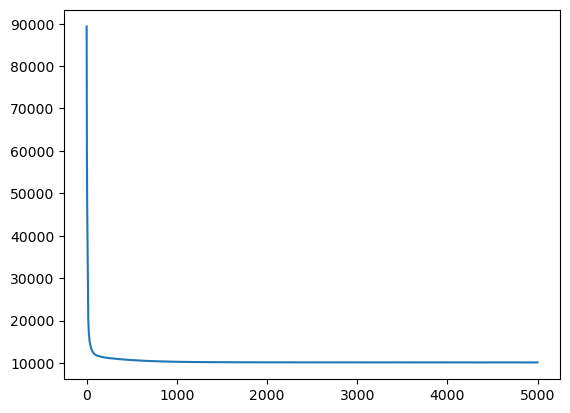

In [9]:
# again, copy our fixed arguments ...
kwargs_fixed = deepcopy(kwargs_partial1)
# before freeing all of those we want optimized here.
del kwargs_fixed['kwargs_background']['h']
del kwargs_fixed['kwargs_background']['mean']
del kwargs_fixed['kwargs_analytic']['a']
del kwargs_fixed['kwargs_analytic']['c_x']
del kwargs_fixed['kwargs_analytic']['c_y']
del kwargs_fixed['kwargs_analytic']['dx']
del kwargs_fixed['kwargs_analytic']['dy']


# same boiler plate code as before, except that we now need to care about the
# regularization of the background.
# calculate the noisemap in each starlet layer:
W = propagate_noise(model, noisemap, kwargs_partial1, wavelet_type_list=['starlet'], 
                    method='SLIT', likelihood_type='chi2', 
                    verbose=False, upsampling_factor=subsampling_factor)[0]


parameters = ParametersDeconv(kwargs_init=kwargs_partial1, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

loss = Loss(data=best_data, 
            deconv_class=model, 
            param_class=parameters, 
            sigma_2=best_noise**2,
            regularization_terms='l1_starlet', 
            W=W,
            regularization_strength_scales=1.0,
            regularization_strength_hf=1.0,
            regularization_strength_positivity=100.,
            regularization_strength_positivity_ps=100.)


optim = Optimizer(loss, parameters, method='adabelief')

# adabelief is very robust, 
optimiser_optax_option = {
                            'max_iterations':5000,
                            'init_learning_rate':1e-3, 'schedule_learning_rate':True,
}           

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)
kwargs_partial2 = deepcopy(parameters.best_fit_values(as_kwargs=True))

plt.figure()
plt.plot(extra_fields['loss_history'])
plt.show()

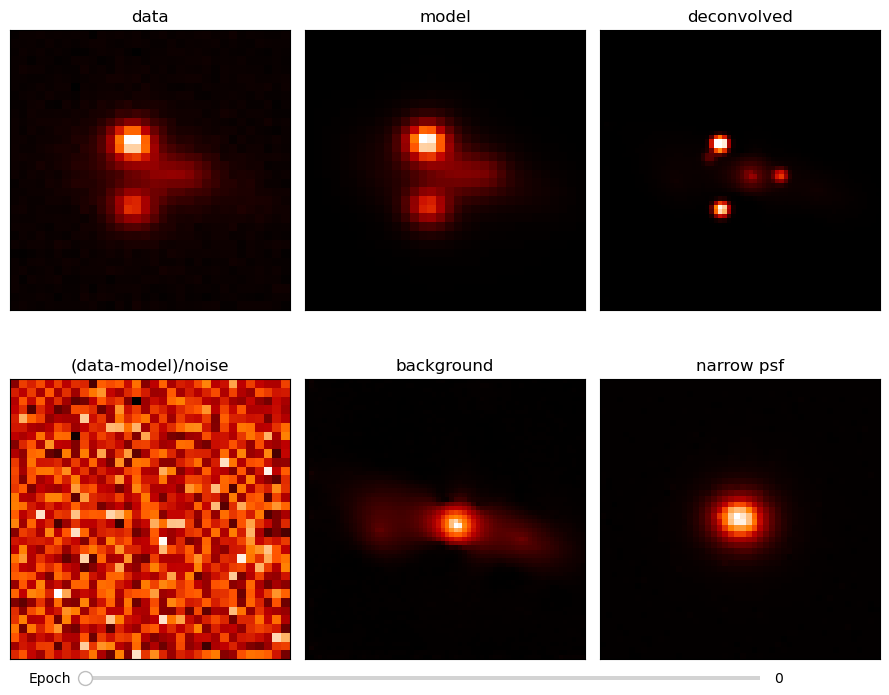

In [10]:
view_deconv_model(model, kwargs_partial2, best_data, best_noise**2)

It seems we've recovered a decent astrometry and background just from the few best seeing frames. The subtracted residuals are also clean, which is reassuring. Now moving on to modelling all epochs at once.

In [11]:
# preparing the initial parameters for the next step:
init_background = kwargs_partial2['kwargs_background']['h'].reshape((im_size_up, im_size_up))
init_c_x = kwargs_partial2['kwargs_analytic']['c_x']
init_c_y = kwargs_partial2['kwargs_analytic']['c_y']
# for the intensities, we'll take the mean of each point source.
intensities = []
M = len(point_sources)
curves = []
for i in range(M):
    curves.append(np.array(kwargs_partial2['kwargs_analytic']['a'][i::M]))
init_a = [np.mean(curve) for curve in curves]
init_a

[11.59404, 6.77792, 2.1205683, 0.6060426]

# Deconvolution of all frames
Very similar to the above, but somewhat more straightforward as we now have a good initial guess.

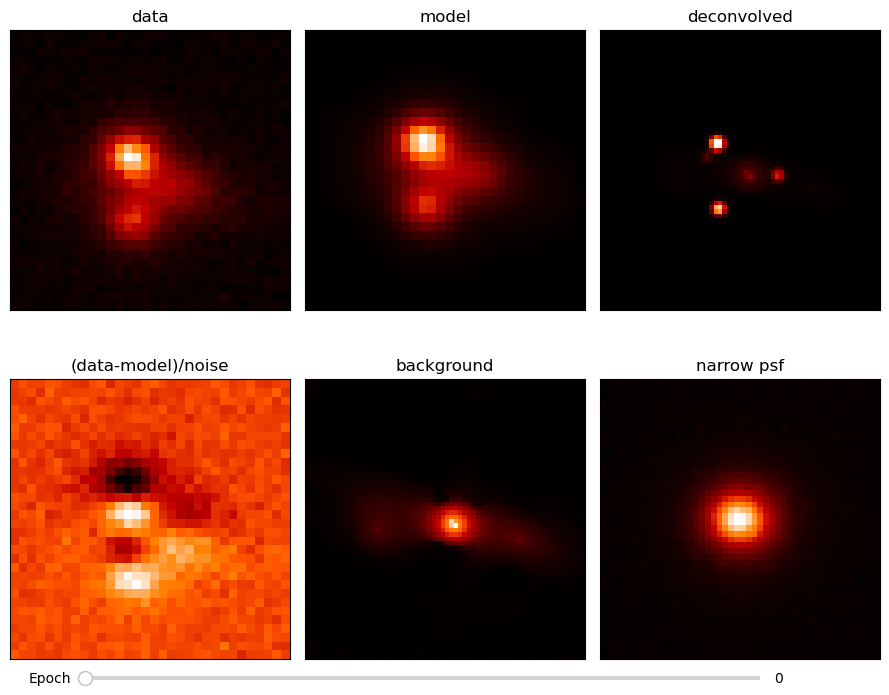

In [12]:
model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(data=data, 
                                                                       sigma_2=noisemap**2, 
                                                                       s=s, 
                                                                       xs=init_c_x,
                                                                       ys=init_c_y,
                                                                       subsampling_factor=subsampling_factor,
                                                                       initial_a=len(data)*init_a)
kwargs_init['kwargs_background']['h'] = init_background.flatten()
# first look at what our model is like given our initial guess:
view_deconv_model(model, kwargs_init, data, noisemap**2)

We start by taking care of the translations, and the flux in each point each in each frame.

/home/fred/Documents/starred_dev/starred/starred/deconvolution/loss.py:135: UserWarning: lambda is not normalized. Provide the weight map !
  warnings.warn('lambda is not normalized. Provide the weight map !')
optax.adabelief: 100%|███████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 101.46it/s]


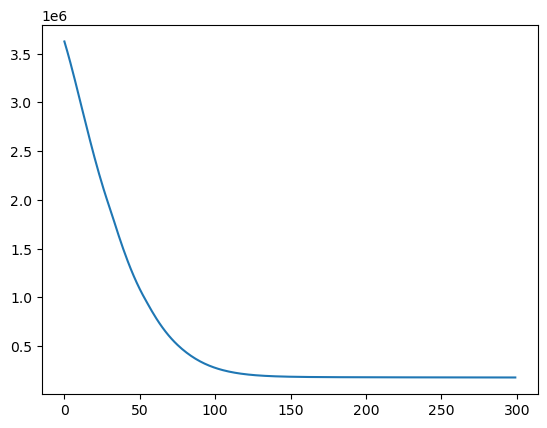

In [13]:
kwargs_fixed = deepcopy(kwargs_init)
del kwargs_fixed['kwargs_analytic']['dx']
del kwargs_fixed['kwargs_analytic']['dy']
del kwargs_fixed['kwargs_analytic']['a']

# martin's last update added lists? converting to array or crash.
for k, v in kwargs_fixed.items():
    for kk, vv in v.items():
        v[kk] = np.array(vv)

parameters = ParametersDeconv(kwargs_init=kwargs_init, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

loss = Loss(data, model, parameters, noisemap**2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=10., 
            regularization_strength_hf=10.,
            regularization_strength_positivity_ps=10.) 


optim = Optimizer(loss, parameters, method='adabelief')

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(max_iterations=300)
kwargs_partial1 = deepcopy(parameters.best_fit_values(as_kwargs=True))

plt.figure()
plt.plot(extra_fields['loss_history'])
plt.show()

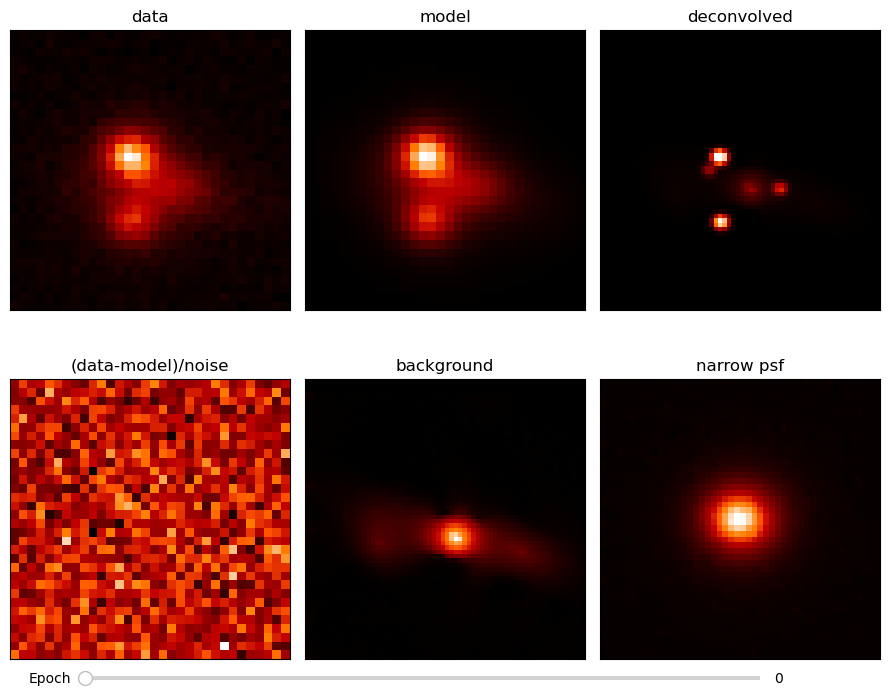

In [14]:
view_deconv_model(model, kwargs_partial1, data, noisemap**2)

We're already getting clean residuals in every epochs, but we can attempt to extract more signal into our background!

optax.adabelief: 100%|███████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 102.92it/s]


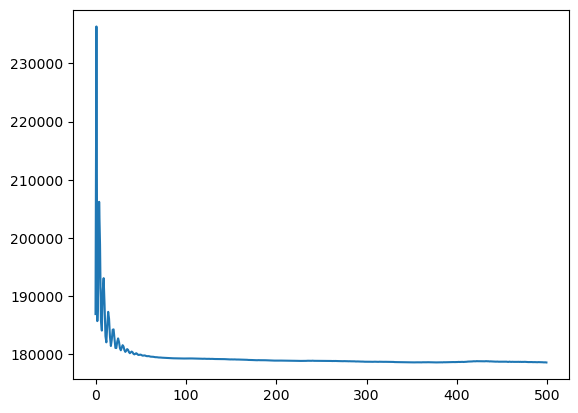

In [15]:
# allow everything to be optimized at once, except the frame rotations which are frankly constant in this dataset.
kwargs_fixed = {
    'kwargs_analytic': {'alpha': kwargs_partial1['kwargs_analytic']['alpha']},
    'kwargs_background': {},#{'mean': kwargs_partial1['kwargs_background']['mean']},
    'kwargs_sersic': {},
}

parameters = ParametersDeconv(kwargs_init=kwargs_partial1, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

loss = Loss(data, model, parameters, noisemap**2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=0.05, 
            regularization_strength_hf=0.07, 
            regularization_strength_positivity=100.,
            regularization_strength_positivity_ps=100.,
            regularization_strength_pts_source=0.025,
            W=W) 


optim = Optimizer(loss, parameters, method='adabelief')


optimiser_optax_option = {
                            'max_iterations':500, 'min_iterations':None,
                            'init_learning_rate':5e-4, 'schedule_learning_rate':0,
                            'restart_from_init':True, 'stop_at_loss_increase':False,
                            'progress_bar':True, 'return_param_history':True
                          }           

best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(**optimiser_optax_option)


kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
# checking how the loss behaved ...
plt.figure()
plt.plot(optim.loss_history)
plt.show()

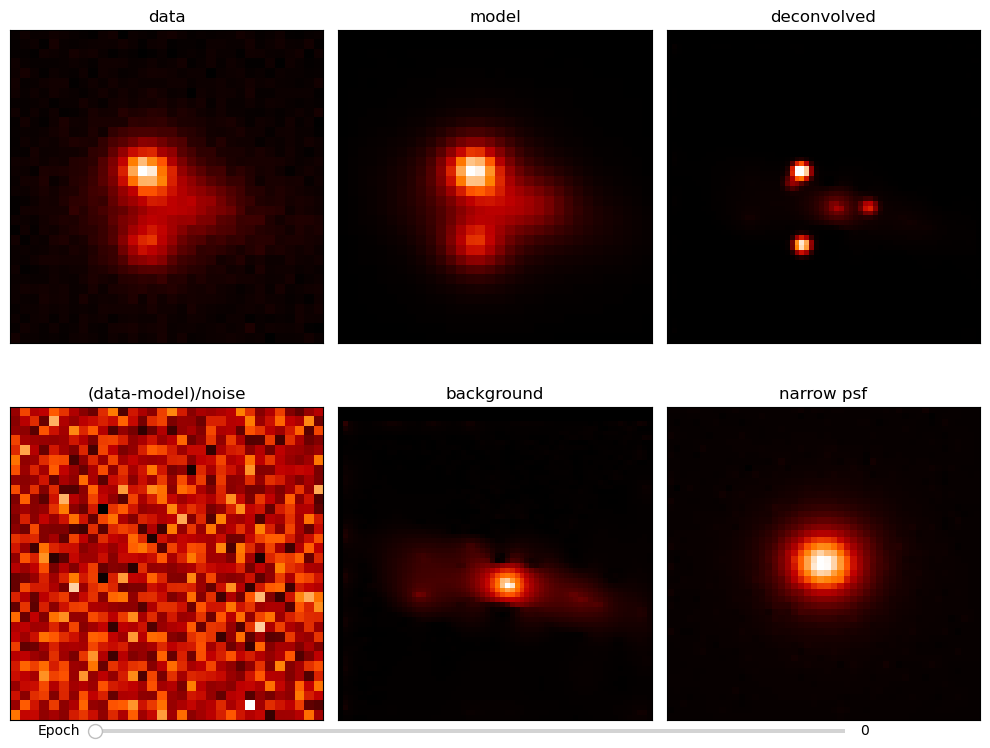

In [16]:
view_deconv_model(model, kwargs_final, data, noisemap**2, figsize=(10,8))

Now just checking the reduced chi2 within each frame, can help identify frames with serious problems:

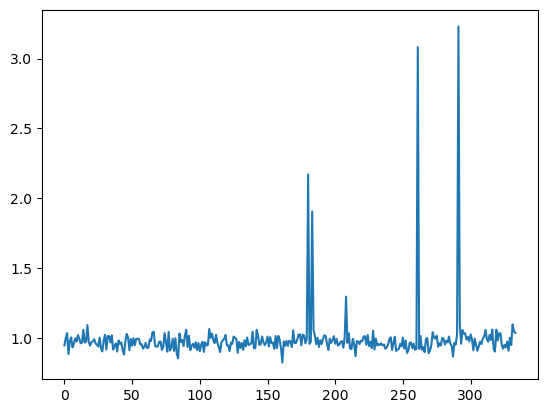

In [17]:
chi2_per_frame = ((data-model.model(kwargs_final))**2 / noisemap**2).sum(axis=(1,2)) / data.shape[1]**2
plt.figure()
plt.plot(chi2_per_frame)

Inspecting some of the frames with a higher chi2, we see that it is mostly due to unmasked cosmics. Thus, not something that went critically wrong.

Alright, using a lightcurver wrapper to get statistical (from the fisher information, calculates the Hessian) uncertainties on each flux.

In [18]:
d_a = get_flux_uncertainties(kwargs=kwargs_final, kwargs_up=kwargs_up, kwargs_down=kwargs_down, 
                             data=data, noisemap=noisemap, model=model) 

/home/fred/Documents/starred_dev/starred/starred/deconvolution/loss.py:135: UserWarning: lambda is not normalized. Provide the weight map !
  warnings.warn('lambda is not normalized. Provide the weight map !')


Extracting the light curves:

In [19]:
# intensities
A = kwargs_final['kwargs_analytic']['a']

# grouping fluxes by point source:
fluxes = {}
M = len(point_sources)
for i, source_label in enumerate(point_sources_labels):
    curve = A[i::M]*scale
    d_curve_hessian = d_a[i::M]*scale
    # let us not forget to add the normalization unceratinty in quadrature!
    norm_errs_abs = np.array(curve)*rel_norm_errs
    d_curve = (norm_errs_abs**2 + d_curve_hessian**2)**0.5
    fluxes[f'{source_label}_flux'] = np.array(curve)
    fluxes[f'{source_label}_d_flux'] = d_curve
# add the meta data
fluxes['mjd'] = mjds
fluxes['zeropoint'] = np.ones_like(d_curve) * zeropoint
fluxes['frame_id'] = frame_ids
fluxes['reduced_chi2'] = np.array(chi2_per_frame)

fluxes = pd.DataFrame(fluxes)
fluxes.head()

,A_flux,A_d_flux,B_flux,B_d_flux,C_flux,C_d_flux,D_flux,D_d_flux,mjd,zeropoint,frame_id,reduced_chi2
0,216.131500,1.073849,133.048813,1.149095,36.346588,1.085138,17.898394,0.980348,59374.381451,25.241967,81,0.948658
1,208.862274,1.093701,130.451233,1.136211,35.593460,1.044018,23.407118,0.953035,59374.386160,25.241967,461,1.000028
2,215.772339,1.061216,132.962738,1.082819,38.605995,0.958929,18.519173,0.887155,59374.390862,25.241967,455,1.036455
3,214.926422,1.166464,133.269562,1.140817,37.810364,1.003927,17.413828,0.916594,59374.395478,25.241967,412,0.887177
4,216.518646,1.292623,134.052704,1.285218,37.203777,1.191430,22.048363,1.064350,59375.366766,25.241967,7,0.979468


In this case, we can never resolve the A and D sources, so let us sum them.

In [20]:
fluxes['AD_flux'] = fluxes['A_flux'] + fluxes['D_flux']
fluxes['AD_d_flux'] = 1 / (1 / fluxes['A_d_flux'] + 1 / fluxes['D_d_flux'])

Now we group by night and convert to magnitudes.

In [21]:
grouped_fluxes = group_observations(fluxes)
mags = convert_flux_to_magnitude(grouped_fluxes)

mags.head()

,mjd,scatter_mjd,zeropoint,frame_id,reduced_chi2,A_flux,A_d_flux,A_scatter_flux,A_count_flux,AD_flux,...,AD_scatter_mag,B_mag,B_d_mag,B_scatter_mag,C_mag,C_d_mag,C_scatter_mag,D_mag,D_d_mag,D_scatter_mag
0,59374.388488,0.006040,25.241967,352.25,0.968079,213.942256,0.548319,2.973885,4,233.262442,...,0.004359,19.936910,0.004617,0.009355,21.316096,0.014888,0.034932,22.030199,0.026274,0.132986
1,59375.373819,0.006059,25.241967,209.25,0.970507,217.314924,0.660430,5.049655,4,237.136351,...,0.010055,19.918064,0.005242,0.006193,21.325983,0.017475,0.037081,22.055790,0.030569,0.372625
2,59376.410905,NaN,25.241967,374.00,0.999383,220.651108,1.340592,0.000000,1,237.590012,...,0.000000,19.924096,0.009962,0.000000,21.238934,0.029787,0.000000,22.169754,0.062792,0.000000
3,59377.382374,0.006038,25.241967,310.50,0.990332,213.890143,0.588951,4.511494,4,232.720715,...,0.008270,19.923363,0.004462,0.004024,21.324652,0.013174,0.036388,22.033230,0.023691,0.275592
4,59378.388677,0.006030,25.241967,242.75,0.993486,215.618339,0.839725,2.377134,4,236.785468,...,0.001771,19.910191,0.005370,0.009439,21.260566,0.012403,0.006951,21.936004,0.021555,0.124061


Let us plot the AD curve!

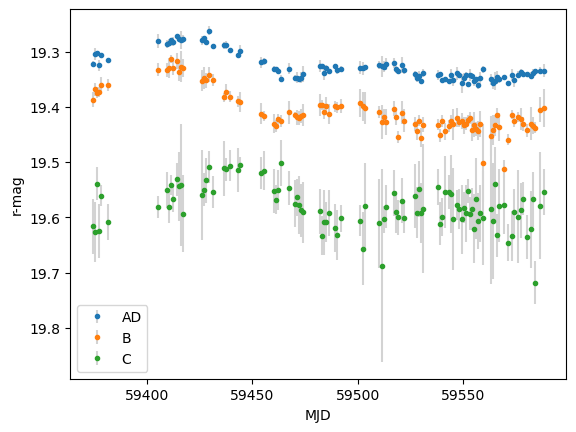

In [22]:
plt.figure()
ps = ['AD', 'B', 'C']
magnitude_offsets = [0, -0.55, -1.7]
for ps, mag_offset in zip(ps, magnitude_offsets):
    plt.errorbar(mags['mjd'], mags[f'{ps}_mag'] + mag_offset, 
                 yerr=mags[f'{ps}_d_mag']+mags[f'{ps}_scatter_mag'],
                 ecolor='lightgray', fmt='.', label=ps)
plt.xlabel('MJD')
plt.ylabel('r-mag')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

We see a clear time delay between each curve! Such time delays can be turned into values of the Hubble constant $H_0$ in the framework of time delay cosmography.

We also see that C is the noisiest, which is not surprising given that is both the faintest, and the most contaminated by the photon noise of the galaxy.